In [3]:
# import libraries 

import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch
from diffusers import AutoencoderKL

/hpc/dctrl/ks723/miniconda3/envs/pytorch_PA_patternprediction/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2025-08-15 15:07:50,709] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [43]:
""" 
This function processes raw experimental patterns and processes them in the desired color format
"""

def preprocess_experimental_initialstage_mod(img_path, img_length=256,img_width=256):

    """
    Preprocess single image in color from rw experimental data.

    Accepts: Input image path 

    Returns: PIL.Image: Color and Cropped image of Experimental data. Cropped exterior is a black masked circle. 

    """

    img = cv2.imread(img_path)

    # Convert the image to grayscale
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find edges in the image using Canny edge detection
    edges = cv2.Canny(img_gray, 100, 200)

    # Find circles in the image using HoughCircles method
    circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, dp=1, minDist=20,
                            param1=50, param2=30, minRadius=20, maxRadius=600)

    # print(circles)

    # Assuming the first detected circle is the plate (adjust accordingly)
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        for (x_center, y_center, radius) in circles:
            # Define a new radius for the mask that is 20 pixels smaller than the detected radius
            new_radius = radius -82
            # print(new_radius)

            # Create a mask where all values are set to zero (black)
            mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8) #np.zeros

            # Draw a filled white circle on the mask where the new, smaller circle is
            cv2.circle(mask, (x_center, y_center), new_radius, (255, 255, 255), -1)

            # Apply the mask to the original image (set pixels outside the new circle to black)
            img_masked = cv2.bitwise_and(img, img, mask=mask)


            # Adjust contrast and brightness
            alpha = 1.5  # Contrast control (1.0-3.0)
            beta = 50    # Brightness control (0-100)
            adjusted_image = cv2.convertScaleAbs(img_masked, alpha=alpha, beta=beta)

            

            # Convert BGR images to RGB for plotting with matplotlib
            img_masked_rgb = cv2.cvtColor(adjusted_image, cv2.COLOR_BGR2RGB)
            # output_img_rgb = cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB)

        

            # resize both the adjusted image and the mask
            img_resized = cv2.resize(img_masked_rgb, (img_length, img_width))
            mask_resized = cv2.resize(mask,(img_length, img_width),interpolation=cv2.INTER_NEAREST)

            # # re-mask the resized image to force a black border outside the circle
            # img_masked_resized = cv2.bitwise_and(img_resized,img_resized,mask=mask_resized)

            # reverse colors outside the circle to white
            # re-mask the resized image with a white background outside the 
            white_value = 255
            output = np.full_like(img_resized, white_value)               # gray background
            output[mask_resized > 0] = img_resized[mask_resized > 0]
            return output



            # return img_masked_resized
    else:
        print("No circles were found")
        return None



In [2]:
"""Function to convert tensor to PIL images"""
def tensor_to_pil_v2(tensor):
    tensor = tensor.permute(1,2,0)  # Convert to  (height, width, channels)
    return [Image.fromarray((img.numpy() * 255).astype('uint8')) for img in tensor]


In [5]:
""" Function to display 3 images in a grid"""

def display_predicted_images(input_seed,final_patterns,pred_images, num_samples):
   
    fig, ax = plt.subplots( 3,num_samples, figsize=(10,6), layout='constrained')  


    # plt.subplots_adjust(wspace=0.001, hspace=0.001)

    for i in range(num_samples):

     
        image_i=tensor_to_pil_v2(input_seed[i,:,:,:])
        image_o=tensor_to_pil_v2(final_patterns[i,:,:,:])
        image_p= tensor_to_pil_v2(pred_images[i,:,:,:].to("cpu"))
      
       

        ax[0,i].imshow(image_i,cmap='gray')
        ax[0,i].get_xaxis().set_visible(False)
        ax[0,i].get_yaxis().set_visible(False)
    

        ax[1,i].imshow(image_o,cmap='gray')
        ax[1,i].get_xaxis().set_visible(False)
        ax[1,i].get_yaxis().set_visible(False)
        

        ax[2,i].imshow(image_p,cmap="gray")
        ax[2,i].get_xaxis().set_visible(False)
        ax[2,i].get_yaxis().set_visible(False)
      
        print(np.array(image_o).shape)
    
    
    plt.show()

In [4]:
"""Scale latents for visualization"""

def scale_latents(latent):
    # Normalize latent for visualization
    latent = latent - latent.min()
    latent = latent / latent.max()
    return latent


(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


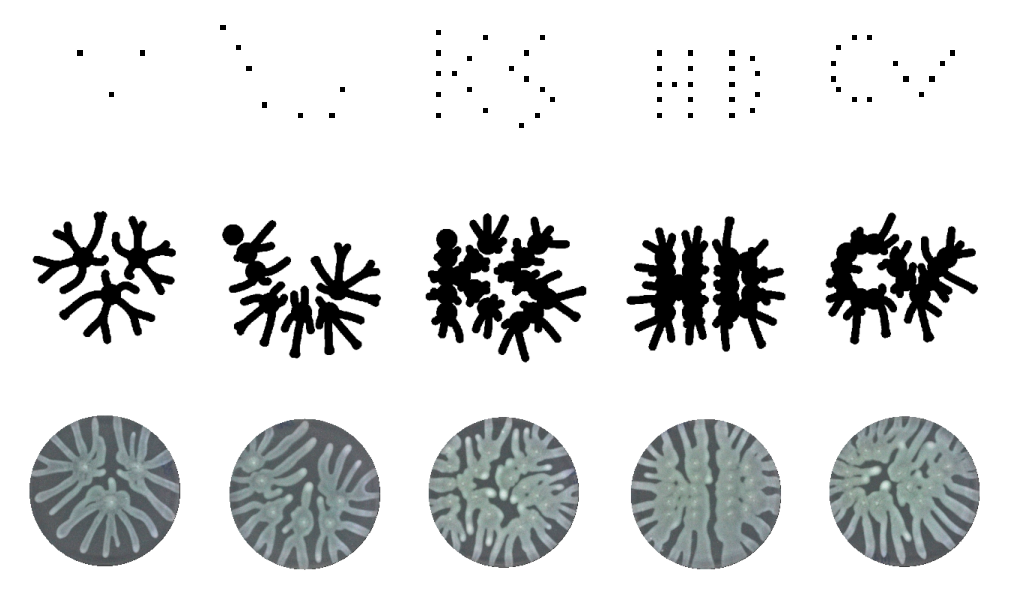

In [23]:
"""
Display experimental patterns, and their corresponding seeds and simulations. Here we select for certain configurations

"""
# Define folder paths for input seeds, experimental, and simulated images
seed_folder = "/hpc/group/youlab/ks723/storage/MATLAB_SIMS/Sim_031524/Sim_output"
experimental_folder = "/hpc/group/youlab/ks723/storage/Exp_images/Final_folder_uniform_fixedseed"
simulated_folder = "/hpc/group/youlab/ks723/storage/MATLAB_SIMS/Sim_031524/Selected_v4_ALL"




selected_files=['Fixed_19_6.TIF','Fixed_15_3.TIF','Fixed_25_4.TIF','Fixed_6_1.TIF','Fixed_26_3.TIF']
simulated_files= [os.path.join(simulated_folder,f) for f in selected_files]
exp_files=[os.path.join(experimental_folder,f) for f in selected_files]

# Derive corresponding seed paths
seed_files = []
for f in selected_files:
    base = os.path.splitext(f)[0]      # e.g. "Fixed_19_6"
    _, x, _ = base.split('_')           # x == "19"
    seed_name = f"Input_Fixed_{x}.png"
    seed_files.append(os.path.join(seed_folder, seed_name))


fig, axes = plt.subplots(3, len(selected_files), figsize=(2*len(selected_files), 6),layout='constrained')
for idx, (seed_p, sim_p, exp_p) in enumerate(zip(seed_files, simulated_files, exp_files)):
    seed_img = Image.open(seed_p).convert('RGB')
    sim_img  = Image.open(sim_p).convert('RGB')

    # inverse transform seed and simulation images
    seed_img_inverse = cv2.bitwise_not(np.array(seed_img))
    
    sim_img_inverse = cv2.bitwise_not(np.array(sim_img))
    sim_img_inverse = cv2.resize(sim_img_inverse, (256, 256))

    
    # remove the small border artifacts by adding a white border 
    sim_img_inverse[0:4, :] = 255
    sim_img_inverse[-4:, :] = 255
    sim_img_inverse[:, 0:4] = 255
    sim_img_inverse[:, -4:] = 255
    

    exp_img  = preprocess_experimental_initialstage_mod(exp_p, img_length=256, img_width=256)

    print(np.array(exp_img).shape)

    axes[0, idx].imshow(seed_img_inverse); axes[0, idx].axis('off')
    axes[1, idx].imshow(sim_img_inverse) ; axes[1, idx].axis('off')
    axes[2, idx].imshow(exp_img, cmap='gray'); axes[2, idx].axis('off')

# fig.get_layout_engine().set(w_pad=0.01, h_pad=0.01, hspace=0.01,
#                             wspace=0.01)
plt.show()


(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


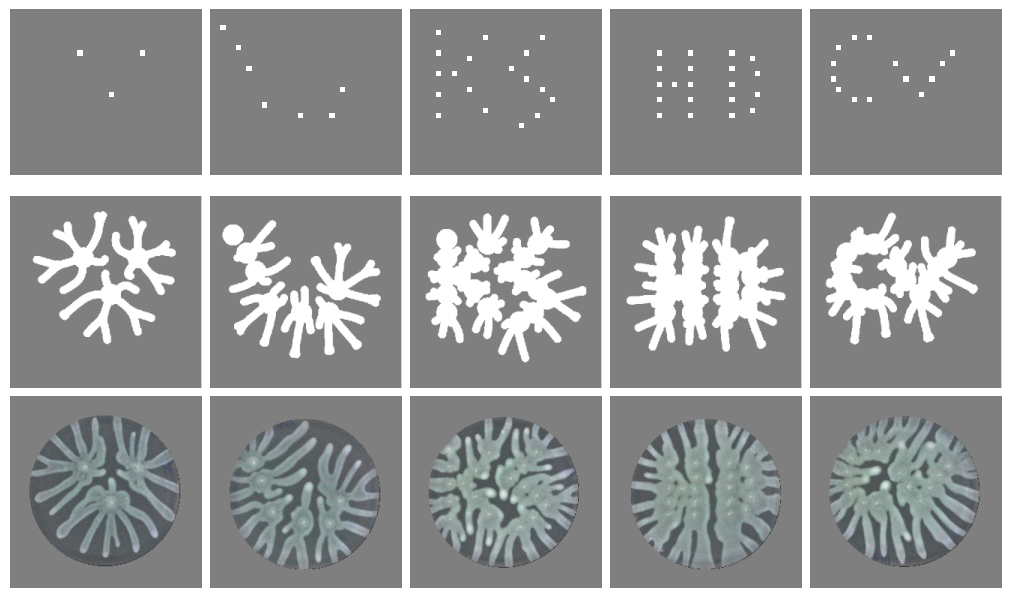

In [29]:
"""
Display experimental patterns, and their corresponding seeds and simulations. Here we select for certain configurations

"""
# Define folder paths for input seeds, experimental, and simulated images
seed_folder = "/hpc/group/youlab/ks723/storage/MATLAB_SIMS/Sim_031524/Sim_output"
experimental_folder = "/hpc/group/youlab/ks723/storage/Exp_images/Final_folder_uniform_fixedseed"
simulated_folder = "/hpc/group/youlab/ks723/storage/MATLAB_SIMS/Sim_031524/Selected_v4_ALL"




selected_files=['Fixed_19_6.TIF','Fixed_15_3.TIF','Fixed_25_4.TIF','Fixed_6_1.TIF','Fixed_26_3.TIF']
simulated_files= [os.path.join(simulated_folder,f) for f in selected_files]
exp_files=[os.path.join(experimental_folder,f) for f in selected_files]

# Derive corresponding seed paths
seed_files = []
for f in selected_files:
    base = os.path.splitext(f)[0]      # e.g. "Fixed_19_6"
    _, x, _ = base.split('_')           # x == "19"
    seed_name = f"Input_Fixed_{x}.png"
    seed_files.append(os.path.join(seed_folder, seed_name))


fig, axes = plt.subplots(3, len(selected_files), figsize=(2*len(selected_files), 6),layout='constrained')
for idx, (seed_p, sim_p, exp_p) in enumerate(zip(seed_files, simulated_files, exp_files)):
    seed_img = Image.open(seed_p).convert('RGB')
    sim_img  = Image.open(sim_p).convert('RGB')

    # grey color for outside region for seed and simulation images
    black_value=0
    grey_value=127
    # replcae all black pixels (0) with grey (127) in seed image
    seed_img_array = np.array(seed_img)
    seed_img_array[np.all(seed_img_array == [black_value, black_value, black_value], axis=-1)] = [grey_value, grey_value, grey_value]
    seed_img_inverse = seed_img_array

    sim_img_inverse = np.array(sim_img)
    sim_img_inverse[np.all(sim_img_inverse == [black_value, black_value, black_value], axis=-1)] = [grey_value, grey_value, grey_value]
    sim_img_inverse = cv2.resize(sim_img_inverse, (256, 256))
    

    exp_img  = preprocess_experimental_initialstage_mod(exp_p, img_length=256, img_width=256)

    print(np.array(exp_img).shape)

    axes[0, idx].imshow(seed_img_inverse); axes[0, idx].axis('off')
    axes[1, idx].imshow(sim_img_inverse) ; axes[1, idx].axis('off')
    axes[2, idx].imshow(exp_img, cmap='gray'); axes[2, idx].axis('off')

# fig.get_layout_engine().set(w_pad=0.01, h_pad=0.01, hspace=0.01,
#                             wspace=0.01)
plt.show()


In [30]:
"""
Display simulated patterns and their corresponding experimental patterns. 

"""

files_list=       ['5_2.TIF','Fixed_14_2.TIF', 'Fixed_29_3.TIF', 'Fixed_15_2.TIF','Fixed_22_1.TIF']
# number of seeds     1         2                   4               6                   8


/hpc/dctrl/ks723/miniconda3/envs/pytorch_PA_patternprediction/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


(32, 32, 4)
(32, 32, 4)
(32, 32, 4)
(32, 32, 4)
(32, 32, 4)


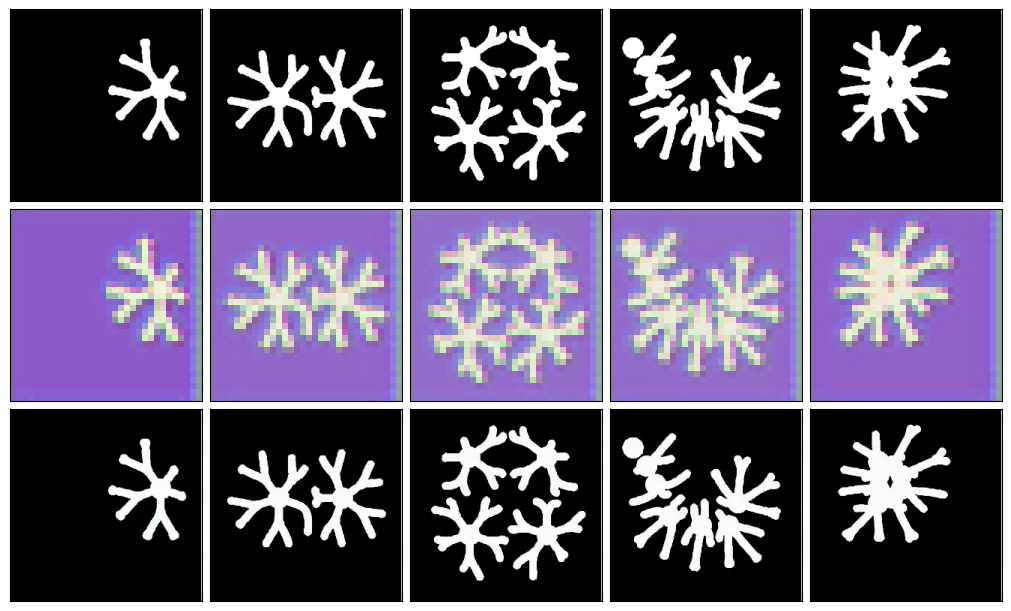

In [31]:
"""Load simulated images, preprocess involves resizing and converting to RGB format """


foldername='/hpc/group/youlab/ks723/storage/MATLAB_SIMS/Sim_031524/Selected_v4_ALL'
sim_img_array=[]

for img in files_list:
    sim_path=os.path.join(foldername,img)
    sim_img=cv2.imread(sim_path, cv2.IMREAD_GRAYSCALE)
    sim_img_array.append(sim_img)

# Set resizing factor
rfactor = 256

# Prepare the simulated data
simulated_data = []

def create_simulated_dataset():
    for img in sim_img_array:

        # Convert BGR to RGB
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Resize it for consistency
        img_rgb_resized = cv2.resize(img_rgb, (rfactor, rfactor))
        simulated_data.append(img_rgb_resized)

    image_shape = simulated_data[0].shape
    return image_shape


shape_row,shape_col,shape_channel=create_simulated_dataset()


X1=simulated_data  
X1 = np.array(X1)
X1 = np.transpose(X1, (0, 3, 1, 2))  # Convert from (N, H, W, C) to (N, C, H, W)
X1 = X1 / 255.0  # Normalize the images

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
X = torch.Tensor(X1)

'''
Define pre-trained SD VAE for encoding simulated patterns and decoding latents back to image space.

'''

# 1. Load the autoencoder model which will be used to decode the latents into image space. 
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

def encode_img(input_img):
    # input_img = input_img.repeat(3, 1, 1)
    
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    if len(input_img.shape)<4:
        input_img = input_img.unsqueeze(0)
    with torch.no_grad():
        latent = vae.encode(input_img*2 - 1) # Note scaling  # to make outputs from -1 to 1 
    return 0.18215 * latent.latent_dist.sample()

def decode_img(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)    # to make outputs from 0 to 1 
    image = image.detach()
    return image


# Encode the images
encoded_latents = []

# encode latent of 100000 images

for img in range(0, X.shape[0]) :
    latent = encode_img(X[img,:,:,:])
    encoded_latents.append(latent)


# Simulating input image data as a list of random torch tensors
input_images_list=encoded_latents

# Convert the list of tensors to a numpy array
image_np = np.concatenate(input_images_list, axis=0)

# # Now final_image_array contains the processed images with the desired properties
# print("Shape of image array:",image_np.shape)

yprime=image_np
yprime=torch.Tensor(yprime)

# scale latent for visualization

yprime_scaled=scale_latents(yprime)
reconstructed_images=decode_img(yprime)


display_predicted_images(X,yprime_scaled, reconstructed_images ,5) # 

(32, 32, 4)
(32, 32, 4)
(32, 32, 4)
(32, 32, 4)
(32, 32, 4)


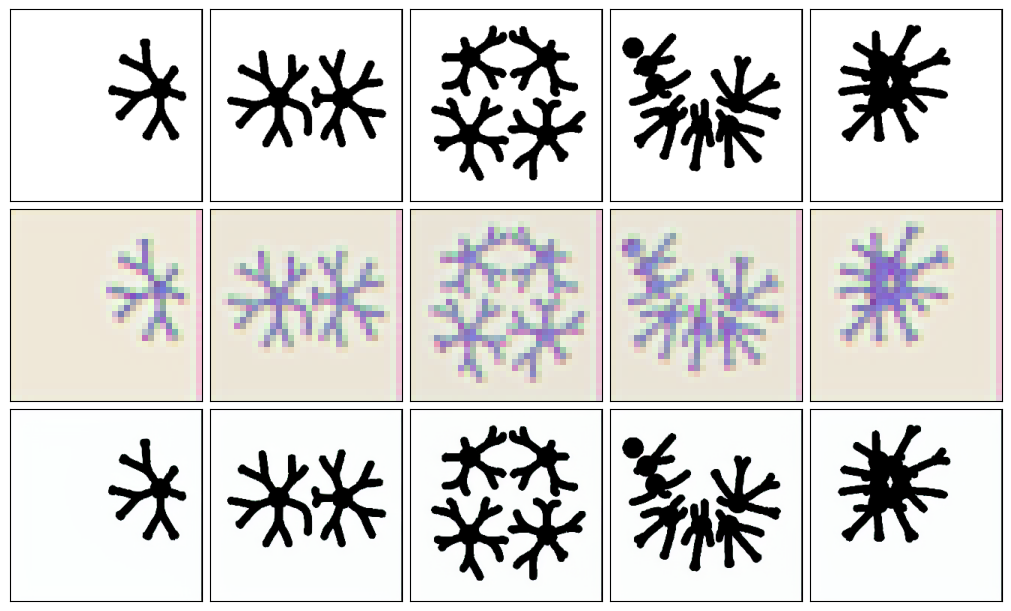

In [32]:
"""Load simulated images, preprocess involves resizing and converting to RGB format """

# black version of simulated images
foldername='/hpc/group/youlab/ks723/storage/MATLAB_SIMS/Sim_031524/Selected_v4_ALL'
sim_img_array=[]

for img in files_list:
    sim_path=os.path.join(foldername,img)
    sim_img=cv2.imread(sim_path, cv2.IMREAD_GRAYSCALE)
    # invert colors: black to white and white to black
    sim_img = cv2.bitwise_not(sim_img)
    sim_img_array.append(sim_img)

# Set resizing factor
rfactor = 256

# Prepare the simulated data
simulated_data = []

def create_simulated_dataset():
    for img in sim_img_array:

        # Convert BGR to RGB
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Resize it for consistency
        img_rgb_resized = cv2.resize(img_rgb, (rfactor, rfactor))
        simulated_data.append(img_rgb_resized)

    image_shape = simulated_data[0].shape
    return image_shape


shape_row,shape_col,shape_channel=create_simulated_dataset()


X1=simulated_data  
X1 = np.array(X1)
X1 = np.transpose(X1, (0, 3, 1, 2))  # Convert from (N, H, W, C) to (N, C, H, W)
X1 = X1 / 255.0  # Normalize the images

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
X = torch.Tensor(X1)

'''
Define pre-trained SD VAE for encoding simulated patterns and decoding latents back to image space.

'''

# 1. Load the autoencoder model which will be used to decode the latents into image space. 
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

def encode_img(input_img):
    # input_img = input_img.repeat(3, 1, 1)
    
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    if len(input_img.shape)<4:
        input_img = input_img.unsqueeze(0)
    with torch.no_grad():
        latent = vae.encode(input_img*2 - 1) # Note scaling  # to make outputs from -1 to 1 
    return 0.18215 * latent.latent_dist.sample()

def decode_img(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)    # to make outputs from 0 to 1 
    image = image.detach()
    return image


# Encode the images
encoded_latents = []

# encode latent of 100000 images

for img in range(0, X.shape[0]) :
    latent = encode_img(X[img,:,:,:])
    encoded_latents.append(latent)


# Simulating input image data as a list of random torch tensors
input_images_list=encoded_latents

# Convert the list of tensors to a numpy array
image_np = np.concatenate(input_images_list, axis=0)

# # Now final_image_array contains the processed images with the desired properties
# print("Shape of image array:",image_np.shape)

yprime=image_np
yprime=torch.Tensor(yprime)

# scale latent for visualization

yprime_scaled=scale_latents(yprime)
reconstructed_images=decode_img(yprime)


display_predicted_images(X,yprime_scaled, reconstructed_images ,5) # 

/hpc/dctrl/ks723/miniconda3/envs/pytorch_PA_patternprediction/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


(32, 32, 4)
(32, 32, 4)
(32, 32, 4)
(32, 32, 4)
(32, 32, 4)


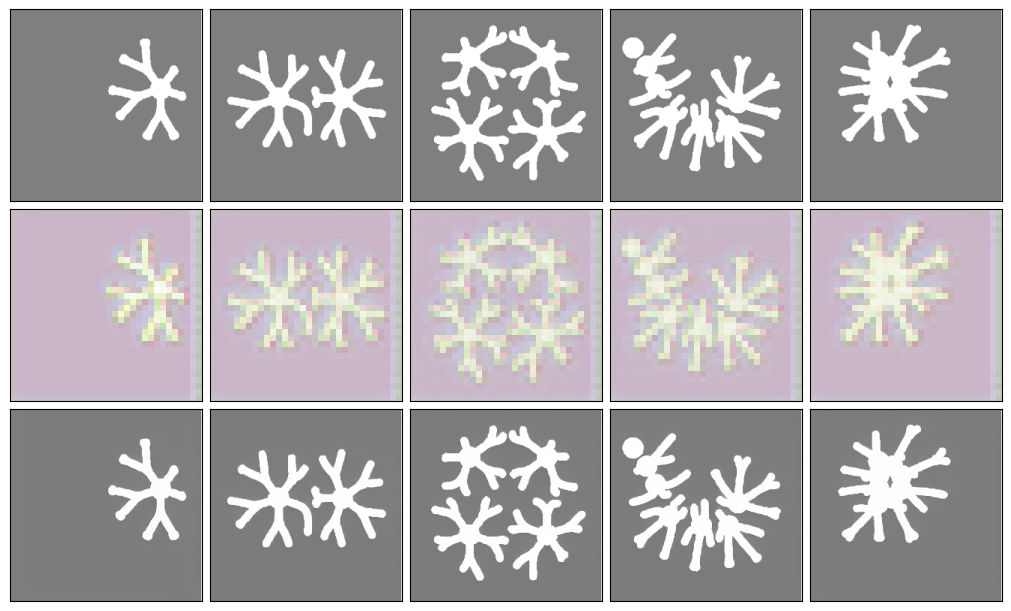

In [38]:
"""Load simulated images, preprocess involves resizing and converting to RGB format """

# gray version of simulated images
foldername='/hpc/group/youlab/ks723/storage/MATLAB_SIMS/Sim_031524/Selected_v4_ALL'
sim_img_array=[]

for img in files_list:
    sim_path=os.path.join(foldername,img)
    sim_img=cv2.imread(sim_path, cv2.IMREAD_COLOR)
    # invert colors: black to white and white to black

    black_value=0
    grey_value=127
    # replcae all black pixels (0) with grey (127) in seed image

    sim_img_inverse = np.array(sim_img)
    sim_img_inverse[np.all(sim_img_inverse == [black_value,black_value, black_value], axis=-1)] = [grey_value,grey_value,grey_value]
    sim_img_inverse = cv2.resize(sim_img_inverse, (256, 256))
    
    sim_img_array.append(sim_img_inverse)

# Set resizing factor
rfactor = 256

# Prepare the simulated data
simulated_data = []

def create_simulated_dataset():
    for img in sim_img_array:

        # Convert BGR to RGB
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Resize it for consistency
        img_rgb_resized = cv2.resize(img_rgb, (rfactor, rfactor))
        simulated_data.append(img_rgb_resized)

    image_shape = simulated_data[0].shape
    return image_shape


shape_row,shape_col,shape_channel=create_simulated_dataset()


X1=simulated_data  
X1 = np.array(X1)
X1 = np.transpose(X1, (0, 3, 1, 2))  # Convert from (N, H, W, C) to (N, C, H, W)
X1 = X1 / 255.0  # Normalize the images

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
X = torch.Tensor(X1)

'''
Define pre-trained SD VAE for encoding simulated patterns and decoding latents back to image space.

'''

# 1. Load the autoencoder model which will be used to decode the latents into image space. 
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

def encode_img(input_img):
    # input_img = input_img.repeat(3, 1, 1)
    
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    if len(input_img.shape)<4:
        input_img = input_img.unsqueeze(0)
    with torch.no_grad():
        latent = vae.encode(input_img*2 - 1) # Note scaling  # to make outputs from -1 to 1 
    return 0.18215 * latent.latent_dist.sample()

def decode_img(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)    # to make outputs from 0 to 1 
    image = image.detach()
    return image


# Encode the images
encoded_latents = []

# encode latent of 100000 images

for img in range(0, X.shape[0]) :
    latent = encode_img(X[img,:,:,:])
    encoded_latents.append(latent)


# Simulating input image data as a list of random torch tensors
input_images_list=encoded_latents

# Convert the list of tensors to a numpy array
image_np = np.concatenate(input_images_list, axis=0)

# # Now final_image_array contains the processed images with the desired properties
# print("Shape of image array:",image_np.shape)

yprime=image_np
yprime=torch.Tensor(yprime)

# scale latent for visualization

yprime_scaled=scale_latents(yprime)
reconstructed_images=decode_img(yprime)


display_predicted_images(X,yprime_scaled, reconstructed_images ,5) # 

In [34]:
sim_img_inverse.shape

(343, 344)

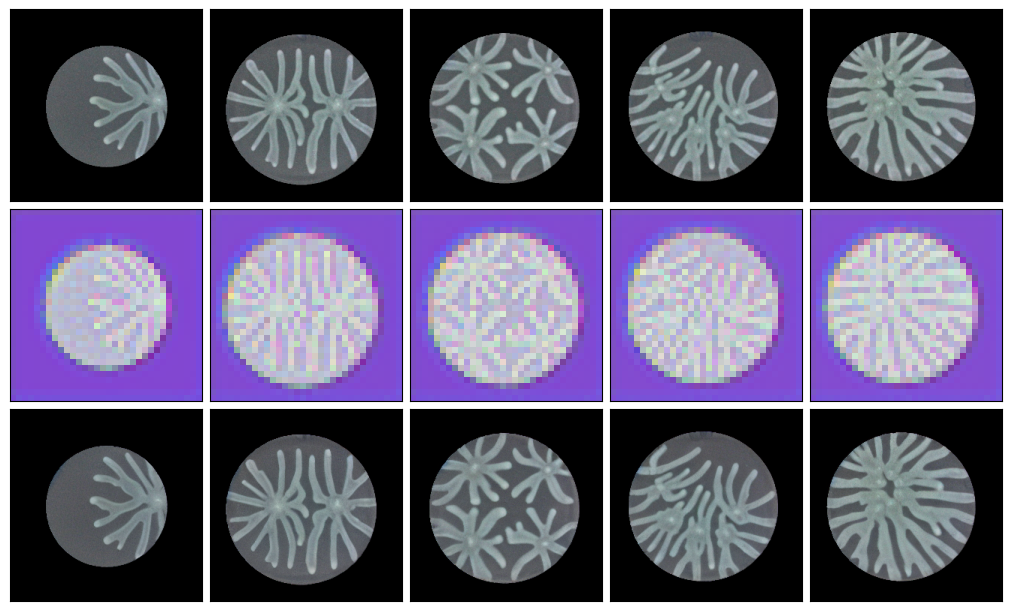

In [9]:

"""Load experimental images, preprocess involves cropping plate and adjusting contrast """

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

rfactor=256  
img_length=rfactor
img_width=rfactor

datadir_exp='/hpc/group/youlab/ks723/storage/Exp_images/Final_folder_uniform_fixedseed' 
path_exp=os.path.join(datadir_exp)

experimental_data=[]

def create_experimental_data():
    img_filenames_i = files_list

    for img in img_filenames_i:

        exp_path= os.path.join(path_exp, img)
        img_array =preprocess_experimental_initialstage(exp_path, img_length=img_length, img_width=img_width)
        experimental_data.append(img_array)
        
            
create_experimental_data()

X=experimental_data  
X=(np.array(X))
X=np.transpose(X, (0,3,1,2))

# normalizing images here to be bw 0 and 1 
X=X/255.0 

# Convert numpy arrays to torch tensors
X = torch.Tensor(X)


'''
Using pre-trained SD VAE for encoding experimental patterns and decoding latents back to image space.

'''

# Encode the images
encoded_latents = []

# encode latent of 100000 images

for img in range(0, X.shape[0]) :
    latent = encode_img(X[img,:,:,:])
    encoded_latents.append(latent)

# Simulating input image data as a list of random torch tensors
input_images_list=encoded_latents

# Convert the list of tensors to a numpy array
image_np = np.concatenate(input_images_list, axis=0)

# # Now final_image_array contains the processed images with the desired properties
# print("Shape of image array:",image_np.shape)

yprime=image_np
yprime=torch.Tensor(yprime)

# scale latent for visualization

yprime_scaled=scale_latents(yprime)
reconstructed_images=decode_img(yprime)

display_predicted_images(X[0:5,:,:,:],yprime_scaled[0:5:,:,:], reconstructed_images[0:5,:,:,:] ,5) # 


(32, 32, 4)
(32, 32, 4)
(32, 32, 4)
(32, 32, 4)
(32, 32, 4)


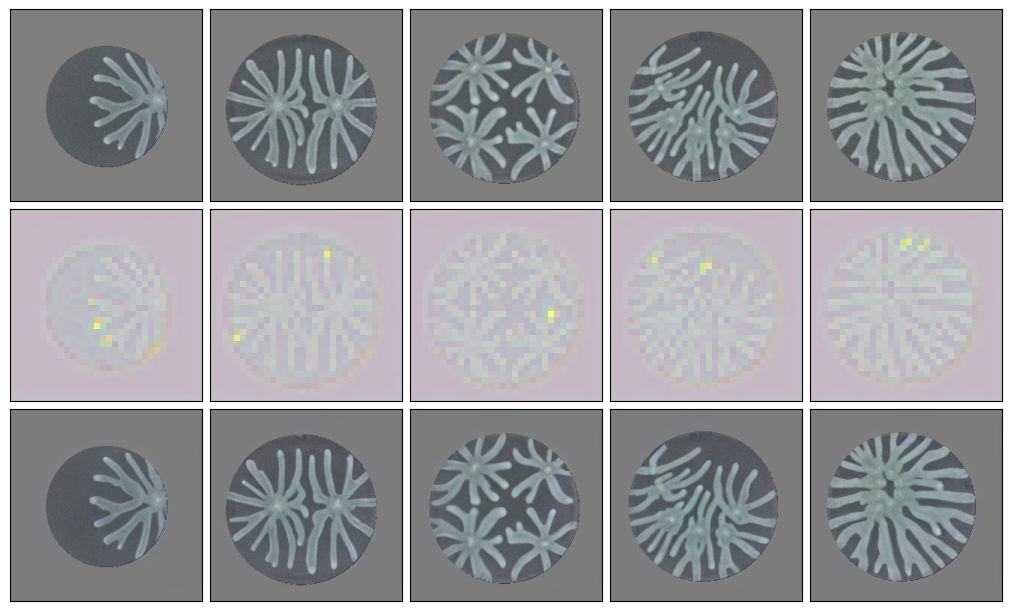

In [39]:

"""Load experimental images, preprocess involves cropping plate and adjusting contrast """

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

rfactor=256  
img_length=rfactor
img_width=rfactor

datadir_exp='/hpc/group/youlab/ks723/storage/Exp_images/Final_folder_uniform_fixedseed' 
path_exp=os.path.join(datadir_exp)

experimental_data=[]

def create_experimental_data():
    img_filenames_i = files_list

    for img in img_filenames_i:

        exp_path= os.path.join(path_exp, img)
        img_array =preprocess_experimental_initialstage_mod(exp_path, img_length=img_length, img_width=img_width)
        experimental_data.append(img_array)
        
            
create_experimental_data()

X=experimental_data  
X=(np.array(X))
X=np.transpose(X, (0,3,1,2))

# normalizing images here to be bw 0 and 1 
X=X/255.0 

# Convert numpy arrays to torch tensors
X = torch.Tensor(X)


'''
Using pre-trained SD VAE for encoding experimental patterns and decoding latents back to image space.

'''

# Encode the images
encoded_latents = []

# encode latent of 100000 images

for img in range(0, X.shape[0]) :
    latent = encode_img(X[img,:,:,:])
    encoded_latents.append(latent)

# Simulating input image data as a list of random torch tensors
input_images_list=encoded_latents

# Convert the list of tensors to a numpy array
image_np = np.concatenate(input_images_list, axis=0)

# # Now final_image_array contains the processed images with the desired properties
# print("Shape of image array:",image_np.shape)

yprime=image_np
yprime=torch.Tensor(yprime)

# scale latent for visualization

yprime_scaled=scale_latents(yprime)
reconstructed_images=decode_img(yprime)

display_predicted_images(X[0:5,:,:,:],yprime_scaled[0:5:,:,:], reconstructed_images[0:5,:,:,:] ,5) # 


(32, 32, 4)
(32, 32, 4)
(32, 32, 4)
(32, 32, 4)
(32, 32, 4)


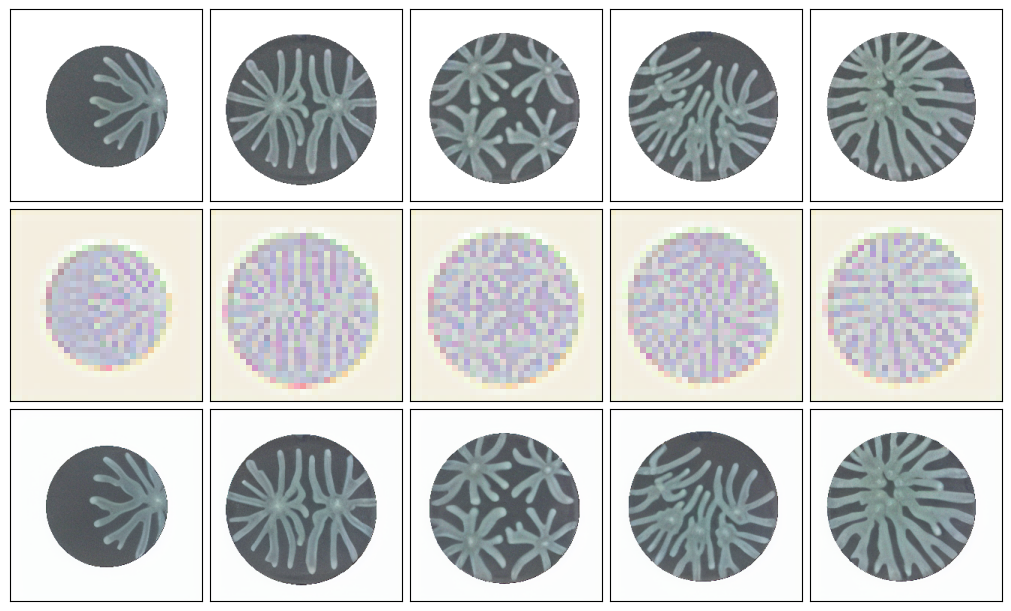

In [44]:

"""Load experimental images, preprocess involves cropping plate and adjusting contrast """

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

rfactor=256  
img_length=rfactor
img_width=rfactor

datadir_exp='/hpc/group/youlab/ks723/storage/Exp_images/Final_folder_uniform_fixedseed' 
path_exp=os.path.join(datadir_exp)

experimental_data=[]

def create_experimental_data():
    img_filenames_i = files_list

    for img in img_filenames_i:

        exp_path= os.path.join(path_exp, img)
        img_array =preprocess_experimental_initialstage_mod(exp_path, img_length=img_length, img_width=img_width)
        experimental_data.append(img_array)
        
            
create_experimental_data()

X=experimental_data  
X=(np.array(X))
X=np.transpose(X, (0,3,1,2))

# normalizing images here to be bw 0 and 1 
X=X/255.0 

# Convert numpy arrays to torch tensors
X = torch.Tensor(X)


'''
Using pre-trained SD VAE for encoding experimental patterns and decoding latents back to image space.

'''

# Encode the images
encoded_latents = []

# encode latent of 100000 images

for img in range(0, X.shape[0]) :
    latent = encode_img(X[img,:,:,:])
    encoded_latents.append(latent)

# Simulating input image data as a list of random torch tensors
input_images_list=encoded_latents

# Convert the list of tensors to a numpy array
image_np = np.concatenate(input_images_list, axis=0)

# # Now final_image_array contains the processed images with the desired properties
# print("Shape of image array:",image_np.shape)

yprime=image_np
yprime=torch.Tensor(yprime)

# scale latent for visualization

yprime_scaled=scale_latents(yprime)
reconstructed_images=decode_img(yprime)

display_predicted_images(X[0:5,:,:,:],yprime_scaled[0:5:,:,:], reconstructed_images[0:5,:,:,:] ,5) # 
